# Bathymetric data

[*GEBCO Compilation Group (2020) GEBCO 2020 Grid (doi:10.5285/a29c5465-b138-234d-e053-6c86abc040b9*)](https://www.gebco.net/data_and_products/gridded_bathymetry_data/)


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png')
import xarray

In [29]:
ds = xarray.open_dataset("../tests/testdata/gebco_2020_n56.3_s55.2_w12.2_e13.1.nc")
ds

<xarray.Dataset>
Dimensions:    (lat: 264, lon: 216)
Coordinates:
  * lat        (lat) float64 55.2 55.21 55.21 55.21 ... 56.29 56.29 56.29 56.3
  * lon        (lon) float64 12.2 12.21 12.21 12.21 ... 13.09 13.09 13.09 13.1
Data variables:
    elevation  (lat, lon) int16 ...
Attributes:
    Conventions:  CF-1.6
    title:        The GEBCO_2020 Grid - a continuous terrain model for oceans...
    institution:  On behalf of the General Bathymetric Chart of the Oceans (G...
    source:       The GEBCO_2020 Grid is the latest global bathymetric produc...
    history:      Information on the development of the data set and the sour...
    references:   DOI: 10.5285/a29c5465-b138-234d-e053-6c86abc040b9
    comment:      The data in the GEBCO_2020 Grid should not be used for navi...
    node_offset:  1.0

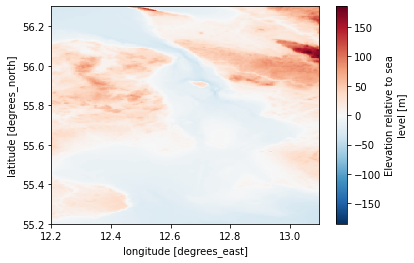

In [30]:
ds.elevation.plot()

In [31]:
ds.elevation.sel(lon=12.74792, lat=55.865, method="nearest")

<xarray.DataArray 'elevation' ()>
array(-43, dtype=int16)
Coordinates:
    lat      float64 55.86
    lon      float64 12.75
Attributes:
    standard_name:       height_above_reference_ellipsoid
    long_name:           Elevation relative to sea level
    units:               m
    sdn_parameter_urn:   SDN:P01::BATHHGHT
    sdn_parameter_name:  Sea floor height (above mean sea level) {bathymetric...
    sdn_uom_urn:         SDN:P06::ULAA
    sdn_uom_name:        Metres

In [32]:
el = ds.elevation.values
el = np.flipud(el)
el.shape

(264, 216)

Dfs2 need a time dimension even if it only has a single timestep.

In [33]:
el = np.expand_dims(el,axis=0)


Set land values to missing values

In [34]:
el = el.astype('float32')
el[el > 0.0] = np.nan

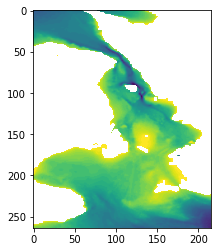

In [35]:
import matplotlib.pyplot as plt
plt.imshow(el[0])

# Coordinates

In [36]:
lat = ds.lat.values
lon = ds.lon.values


nx = len(lon)
ny = len(lat)

dx = (lon[-1] - lon[0]) / (nx-1)
dy = (lat[-1] - lat[0]) / (ny-1)

x0 = lon[0]
y0 = lat[0]


x0, y0, nx, ny, dx, dy

(12.20208333333332,
 55.20208333333332,
 216,
 264,
 0.004166666666666711,
 0.00416666666666666)

# Create dfs2


In [37]:
from mikeio.eum import EUMType, EUMUnit

from mikeio import Dfs2, Dataset
from mikeio.eum import ItemInfo

dfsfilename = "gebco_sound.dfs2"

coordinate = ['LONG/LAT', x0, y0, 0]

ds = Dataset(data=[el], time=pd.date_range("2018", periods=1, freq='D'), items=[ItemInfo("Elevation", EUMType.Total_Water_Depth)])

dfs = Dfs2()
dfs.write(filename=dfsfilename,
           data=ds,
           coordinate=coordinate, dx=dx, dy=dy,      
)

# Read the file

In [38]:
newdfs = Dfs2(dfsfilename)
newdfs

<mikeio.Dfs2>
dx: 0.00417
dy: 0.00417
Items:
  0:  Elevation <Total Water Depth> (meter)
Time: time-invariant file (1 step)

In [39]:

newds = newdfs.read()

newds

<mikeio.Dataset>
Dimensions: (1, 264, 216)
Time: 2018-01-01 00:00:00 - 2018-01-01 00:00:00
Items:
  0:  Elevation <Total Water Depth> (meter)

Find index of the deepest point (55.865N, 12.74792E)

In [40]:
k,j = newdfs.find_nearest_elements(lon=12.74792,lat=55.865)
print(k,j)

104 131


In [41]:
newds.data[0][0,k,j]

-43.0

# Clean up

In [42]:
import os
os.remove(dfsfilename)